# Classification

- Data MNIST dataset from sklearn
    - includes over 70k small images of digits handwritten by high school students & employees of the US census bureau

## Imports

In [1]:
import sklearn
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.base import clone, BaseEstimator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve

import numpy as np
import os

import matplotlib as mpl
import matplotlib.pyplot as plt

## Acquiring data

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)

mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

mnist data description

In [3]:
mnist.DESCR

"**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 

checking out the data arrays

## exploring

In [4]:
X, y = mnist['data'], mnist['target']

X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

It seems that there are 70,000 images and each image has 784 features

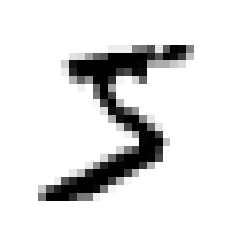

In [6]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

looks like a '5'

In [7]:
y[0]

'5'

indeed it is a 5

also, from seeing the '' around the 5 it seems like the labels in the np array on the y array arre all strings
- changing them to integers

In [8]:
y = y.astype(np.uint8)

# splitting our data

In [9]:
# its already split
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[:60000], y[:60000]

## creating a binary classifier
- baseline

In [10]:
y_train_5 = (y_train == 5) # True for all 5's, False for all other digits
y_test_5 = (y_test == 5)

Stochastic gradient descent classifier from sklearn

In [11]:
# initiating the thing
sgd_clf = SGDClassifier(random_state=42)
# fit the thing
sgd_clf.fit(X_train, y_train_5)
# use the thing
sgd_clf.predict([some_digit])

array([ True])

### looks like it works on a small scale

## Evaluating our model using CV's

In [12]:
# using stratified kfolds to cross validate our classification model from scratch
skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.8787
0.8495
0.85815


In [13]:
# using cross_val_score from sklearn
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [14]:
# lets evaluate our model using a baseline estimator
# creating a classifier that predicts a number is not 5
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)    

In [15]:
never_5_clf = Never5Classifier()

cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

# using a confusion matrix to evaluate our model

In [16]:
# initializing our confusion matrix
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
# using our confusion matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [17]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [18]:
# evaluting with precision and recall
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [19]:
# recall
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [20]:
# f1 score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### decision score threshold

In [21]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [22]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

How to know what threshold to use?
- use a cross_val_predict() function to get the scores of all instances in the training set, but this time specifiy that you want to return decision scores instead of predictions

In [23]:
# example
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

- then with these scores, use the precision_recall_curve() to compute precision & recall for all possible thresholds:

In [24]:
precision, recall, thresholds = precision_recall_curve(y_train_5, y_scores)

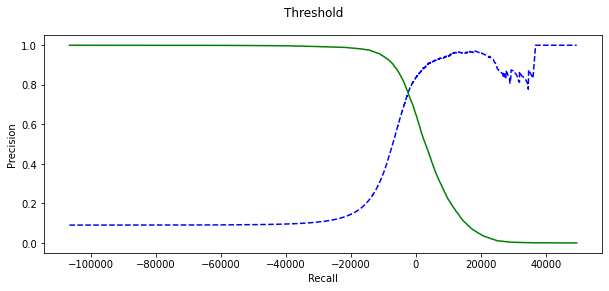

In [37]:
# plotting our threshold using matplotlib
def plot_precision_recall(precision, recall, thresholds):
    plt.figure(figsize=(10,4))
    plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
    plt.suptitle('Threshold')
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    
    plt.show()

plot_precision_recall(precision, recall, thresholds)

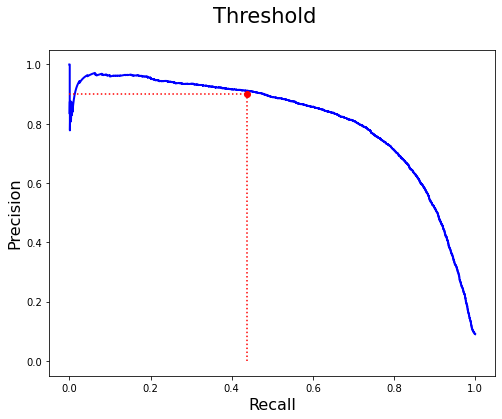

In [56]:
# another way to visualize where our threshold is

def plot_precision_recall2(precision, recall):
    plt.plot(recall, precision, 'b-', linewidth=2)
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.suptitle("Threshold", fontsize=21)
    plt.axis=([0,1,0,1])
    plt.grid=True
    
plt.figure(figsize=(8, 6))
plot_precision_recall2(precision, recall)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
plt.show()  
    
    

- precision starts to fall around 80%
- so we're going to aim for a 90% precision

In [58]:
threshold_90_precision = thresholds[np.argmax(precision >= 0.90)]
# and we use the above code to make our prediction
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [59]:
# and we check our preicison and recall again
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [60]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

it's super easy to create a precision classifier that has over 90%. and since the recall is so low, that makes it not very useful
We're going to use a ROC curve (**Receiver Operating Characteristic**) Curve,m which is similar to the precision/recall curve, but instead of plotting precision vs recall, we plot the true positive rate against the false positive rate.

basically an ROC curve is plotting recall vs type 2 errors